<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

/bin/bash: line 1: apt-get: command not found


firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


**Part 2 - Computing the PDF**

**A) Theory**

Having constructed a finite element approximation of the CDF $\mathsf{F}(y)$ we now turn to constructing its PDF which must remain positive and integrate to one. While strictly speaking the PDF is the derivative of the CDF, the CDF obtained in **Part 1** is discontinuous and therefore a classical derivative can only be defined within each element $\Omega_e$. At the elements' boundaries $\partial \Omega_e$ there is a jump in the CDF, and as a consequence $\mathsf{F}(y)$ has neither a classical nor a weak derivative at these points. Instead a distributional derivative must be used (cf. [Ern, A., Guermond, JL. (2021)](https://doi.org/10.1007/978-3-030-56341-7_4)). This distinction leads us to define the PDF as the distribution
\begin{equation}
f[v] = \int_{\Omega_Y} v(y) d\mathsf{F}(y),
\end{equation}
where $v \in C_0(\Omega_Y)$ is an appropriate test function. Although the PDF cannot be expressed as a function, Lebesgue's decomposition theorem (cf. [Rudin, W. (1987)](https://perso.telecom-paristech.fr/decreuse/_downloads/c22155fef582344beb326c1f44f437d2/rudin.pdf)) (and the finite dimensional setting of this problem) allows this distribution to be written as a sum of two continuous linear functionals
\begin{equation}
\mathsf{f}_Y[v] = \langle v, \mathsf{f}_0 \rangle_{V_0} + \langle v, \mathsf{f}_1 \rangle_{V_1},
\end{equation}
over the Hilbert spaces $V_0$ and $V_1$ associated with the continuous part of the PDF within the $N_e$ elements $\Omega_e$, and the singular contribution to the PDF from jumps at the $N_e + 1$ facets $\Gamma$. This is useful because although we cannot calculate the functional form of the PDF, we can compute its Riesz representation as the functions $\mathsf{f}_0(y) \in L^2(\Omega_Y)$ and $\mathsf{f}_1(y) \in L^2(\Gamma)$. 

*Boundary conditions*

To obtain the projections for $\mathsf{f}_0$ and $\mathsf{f}_1$ we integrate by parts over a single element 

\begin{equation} 
    \int_{\Omega_e}  v(y) \partial_y \mathsf{F}_Y(y) \, d y =  - \int_{\Omega_e} \left( \partial_y v(y) \right) \mathsf{F}_Y(y) \, d y +  v(y) \mathsf{F}_Y(y) \bigg|_{\partial \Omega_e },
\end{equation}
and then sum over all elements to obtain the contribution to $\mathsf{f}_0$ from within elements and the contribution to $\mathsf{f}_1$ from the element boundaries

\begin{equation}
    \mathsf{f}_Y[v] = \underbrace{- \sum_{e=1}^{N_e} \int_{\Omega_e} \left( \partial_y v(y) \right) \mathsf{F}_Y(y) \, d y}_{:= \langle v, \mathsf{f}_0 \rangle_{V_0}} + \underbrace{ \sum_{y_e \in \Gamma} - v(y_e) [[\mathsf{F}_Y(y_e)]] }_{:= \langle v, \mathsf{f}_1 \rangle_{V_1}},
\end{equation} 
where $[[\mathsf{F}_Y(y_e)]] = \mathsf{F}^+_Y(y_e) - \mathsf{F}^-_Y(y_e)$ corresponds to the jump at each facet $y_e \in \Gamma$.  Although $[[\mathsf{F}_Y(y_e)]]$ is defined at all interior facets, because we use a finite domain, we must specify the behaviour of $\mathsf{F}_Y(y)$ at the boundary $\partial \Omega_Y$. If $\Omega_Y$ is chosen such that the range of $Y(x)$ is a subset of the domain (i.e. $\text{Range}(Y(x)) \subseteq \Omega_Y$), then we must impose Dirichlet boundary conditions to account for any mass lost due to discretisation error. This translates to specifying

\begin{equation}
    [[\mathsf{F}_Y(y_e = y_{\text{min}})]] = \mathsf{F}^+_Y(y_e = y_{\text{min}}) - 0
\end{equation}
at the lower boundary and 

\begin{equation}
    [[\mathsf{F}_Y(y_e = y_{\text{max}})]] = 1- \mathsf{F}^-_Y(y_e = y_{\text{max}})
\end{equation}
at the upper boundary. As the discretisation error reduces with increasing resolution, $\mathsf{F}_Y(y)$ will tend to $0$ and $1$ at the lower and upper boundaries respectively and so this jump will tend to zero. Alternatively, if the domain is a subset of the range of $Y(x)$ (i.e. $\text{Range}(Y(x)) \supset \Omega_Y$), the PDF should not integrate to one as we do not want to account for the mass beyond the end points of the domain. Although the boundary conditions for this case correspond to inhomogeneous Neumann boundary conditions, it is easily treated by specifying $ [[\mathsf{F}_Y(y_e = y_{\text{max}})]] =  [[\mathsf{F}_Y(y_e = y_{\text{min}})]] =0$, which follows from the fact that continuity of the derivative at the boundary of $\partial \Omega_Y$ implies that the jump is zero.

*Element interior*

As a consequence of defining the PDF as a distribution and because we choose that $\mathsf{F}_Y(y)$ lives in the space of discontinuous piecewise linear functions, $\mathsf{f}_0$ lies within the space of discontinuous piecewise constant functions. Therefore to recover $\mathsf{f}_0$, the Riesz representor of $\mathsf{f}_Y[v]$ within the element, we define the basis $V_0 = \text{span}\{\varphi_i(y)\}$ such that $\mathsf{f}_0(y) = \sum_i \mathsf{f}^i_0 \varphi_i(y)$. As element boundaries in $L^2(\Omega_Y)$ have measure zero, integrating over all elements is equivalent to integrating over the domain $\sum_{e=1}^{N_e} \int_{\Omega_e} \cdot \; dy = \int_{\Omega_Y} \cdot \; dy$. This implies that contribution of the boundary terms are zero when calculating  $\mathsf{f}_0$ and that the projection is simply given by

\begin{equation}
    \int_{\Omega_Y} v(y) \mathsf{f}_0(y) \, d y = \int_{\Omega_Y} v(y) \partial_y \mathsf{F}_Y(y) \, d y, \quad \text{where} \quad v \in V_0.
\end{equation}

*Element facets*

To recover $\mathsf{f}_1$, the Riesz representor of $\mathsf{f}_Y[v]$ at the element facets, we can define the projection over the set of facets as the point evaluation of the jump in the CDF at each facet. Choosing the space of piecewise continuous linear functions (also known as CG1) with nodes at the cell boundaries and defining the basis $V_1 = \text{span}\{\varphi_i(y)\}$ such that $\mathsf{f}_1(y) = \sum_i \mathsf{f}^i_1 \varphi_i(y)$, we define the projection over the set of facets as

\begin{equation}
    \mathsf{f}^i_1 = - \sum_{y_e \in \Gamma} \varphi_i(y_e) [[\mathsf{F}_Y(y_e)]], \quad \text{where} \quad \varphi_i \in V_1.
\end{equation}

If the true CDF $F_Y$ is smooth and continuous, the jumps in its finite element approximation $[[\mathsf{F}_Y(y_e)]]$ at the facets will tend to zero as the approximation converges. On the other hand should the true CDF contain a step corresponding, for example, to a region of $\Omega_X$ where $Y(x)$ is constant (as indicated in the schematic shown in \textbf{Part 1}), the jump $[[\mathsf{F}_Y(y_e)]]$ will be correctly associated with a Dirac measure (cf. [Ern, A., Guermond, JL. (2021)](https://doi.org/10.1007/978-3-030-56341-7_4)). As we now demonstrate numerically, defining the finite element approximation of the PDF $\mathsf{f}_Y[v]$ in terms of distribution provides a mathematically consistent formulation which allows us to ensure that the projection of derivative of the CDF does not loose mass, while applying the Riesz representation theorem allows us to visualize the PDF in terms of how $\mathsf{f}_0, \mathsf{f}_1$ acts on functions.

**B) Numerical implementation**

To demonstrate our method of recovering $\mathsf{f}_0$ and $\mathsf{f}_1$ we will make use of the function 
\begin{equation}
Y(x_1) = \begin{cases} 0 \quad x_1 < 0, \\ x \quad x_1 \geq 0, \end{cases} 
\end{equation}
where $x_1 \in [-1,1]$. This function is useful because its CDF contains a step and therefore its corresponding PDF will contain a Dirac distribution. To simplify the presentation we use the *NumDF* library (imported below) which implements the methods used in **Part 1**. 

In [2]:
from numdf import Ptp
import numpy as np
from firedrake import *

We begin by creating an instance of the *Ptp* class by specify the physical domain $\Omega_X$, the domain of the CDF $\Omega_Y$ and a number of elements. As justified in Part1 a discontinuous piecewise linear 'DG1' function space is selected by default for the CDF.

In [3]:
# Specify the domain sizes and number of elements
ptp = Ptp(Omega_X = {'x1': (-1, 1)}, Omega_Y = {'Y': (-1, 1)}, n_elements=10)

We then specify our function $Y(x_1)$ in terms of the coordinates of the domain and generate its CDF by calling the fit method.

In [4]:
# Extract the coordinates
x1 = ptp.x_coords()
Y = conditional(ge(x1, 0), x1, 0)
density = ptp.fit(Y=Y, quadrature_degree=200)

Using the density object we can then plot the CDF, which contains a step at $y=0$.

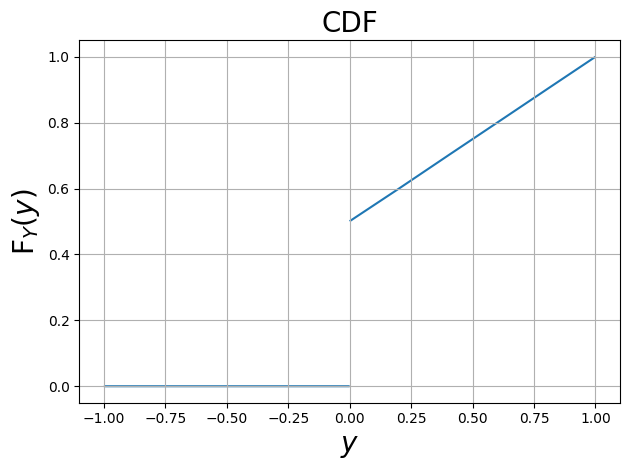

In [5]:
density.plot('CDF')

We first compute the projection of $\partial_y \mathsf{F}_Y(y)$ into $L^2(\Omega_Y)$ by specifying a discontinuous piecewise constant function space $V_{\mathsf{f}_0}$ for $\mathsf{f}_0(y)$ also known as 'DG0'. This choice naturally follows from the fact that $\mathsf{F}_Y(y)$ lives in 'DG1' and so its derivative should live in the lower order space 'DG0'.

In [6]:
def compute_f0_pdf(F):
    """Compute f_0(y) as the derivative of CDF F(y) within the elements."""

    # Grab the mesh associated with the CDF
    mesh = F.function_space().mesh()

    # Define a function space for the PDF
    V_f0 = FunctionSpace(mesh=mesh,family="DG",degree=0)

    u = TrialFunction(V_f0)
    v = TestFunction(V_f0)

    # Define the variational form
    a = inner(u,v)*dx
    L = inner(F.dx(0),v)*dx

    # Solve for f0
    f0 = Function(V_f0)
    solve(a == L, f0)
    
    return f0

To realise the Riesz representor $\mathsf{f}_1$ associated with the jump discontinuities at each facet, we can project the distribution into the space of continuous functions 'CG1' whose basis
\begin{equation}
\varphi_i(y_j) = \delta_{ij}, \quad \delta_{ij} = \begin{cases} 1 \quad i = j, \\ 0 \quad i \neq j, \end{cases}
\end{equation}
if restricted to the set of cell facets naturally represents our measure. To compute $[[\mathsf{F}]]_e$ we make use of the $\texttt{jump}$ operator (part of the UFL form language) which evaluates the difference between the restrictions of the given expression on the positive and negative sides of the facet. The restriction to the cell facets is implemented by making use of the interior and exterior measures $\texttt{dS}$ and $\texttt{ds}$. At the exterior facets we impose either a Dirichlet or Neumann boundary condition on $\mathsf{F}$ in order to evaluate the jump and finally the $\texttt{avg}$ operator used below is also required when using $\texttt{dS}, \texttt{ds}$.

In [7]:
def compute_f1_pdf(F):
    """Compute f1 the riesz representor of the distributional derivative of CDF F(y) at the element facets."""

    # Grab the mesh associated with the CDF
    mesh = F.function_space().mesh()
    
    # Determine Omega_Y
    y      = mesh.coordinates.dat.data[:]
    Omega_Y = np.array([min(y), max(y)])

    # Determine range of Y(x1)
    Range_Y = np.array([0, 1]) 

    # Define a function space for the test function
    V_f1 = FunctionSpace(mesh=mesh, family="CG", degree=1)

    u = TrialFunction(V_f1)
    v = TestFunction(V_f1)

    if min(Omega_Y) < min(Range_Y):
        # Dirichlet BC at the left boundary
        L_left = (F-0)*v*ds(1)
    else:
        # Neumann BC at the left boundary
        L_left = 0

    if max(Omega_Y) > max(Range_Y):
        # Dirichlet BC at the right boundary
        L_right = (F-1)*v*ds(2)        
    else:
        # Neumann BC at the right boundary
        L_right = 0

    # Define the variational form for the:
    #      interior facets                 exterior facets
    a = inner(avg(u),avg(v))*dS  +          inner(u,v)*ds
    L = -jump(F)*avg(v)*dS       -  ( L_right - L_left )

    # Solve for fs
    f1 = Function(V_f1)
    solve(a == L, f1)

    return f1

Having defined these two functions we then pass the CDF computed in order to recover the distribution $\mathsf{f}[v]$ in terms of $\mathsf{f}_0$ and $\mathsf{f}_1$.

In [8]:
# Compute f0 within the elements
f0 = compute_f0_pdf(density.cdf)

# Compute fs at the element boundaries
f1 = compute_f1_pdf(density.cdf)

Below we plot $\mathsf{f}[v]$ in terms of $\mathsf{f}_0$ (solid line) and $\mathsf{f}_1$ (vertical dashed blue line)

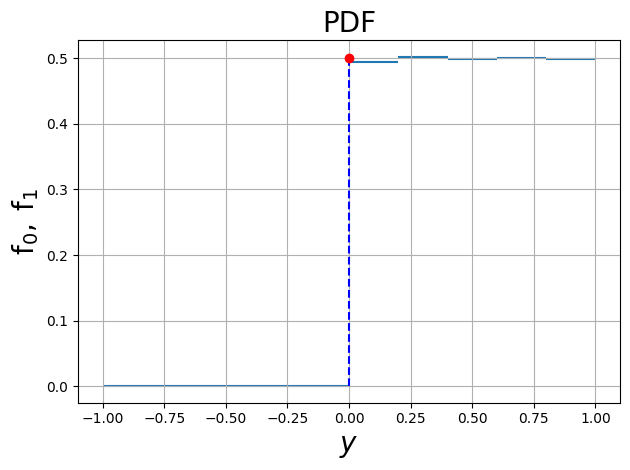

In [9]:
import matplotlib.pyplot as plt
from firedrake.pyplot import plot

# Plot the piecewise constant component
plot(f0, num_sample_points=50)

# Plot the singular component
m_y = f1.function_space().mesh()
loc = m_y.coordinates.dat.data[:]
jump = f1.dat.data[:]

y = np.linspace(0,1,50)
for j_i,y_i in zip(jump,loc): 
    plt.plot(y_i*np.ones(50),j_i*y,'b--')
    if abs(j_i) > 1e-03: plt.plot(y_i,j_i,'ro')

# Label the plot
plt.title(r'PDF',fontsize=20)
plt.ylabel(r'$\mathsf{f}_0, \; \mathsf{f}_1$',fontsize=20)
plt.xlabel(r'$y$',fontsize=20)
plt.tight_layout()
plt.grid()
plt.show()

Finally to check that this projection has conserved mass we integrate the distribution $\mathsf{f}[v=1]$ below

In [10]:
int_f = assemble(f0*dx)  +  assemble(f1*ds + avg(f1)*dS)

print('f[v=1] = <1,f_0> + <1, f_1> = %e' % int_f)

f[v=1] = <1,f_0> + <1, f_1> = 1.000000e+00


In **Part 1** a discontinuous piecewise linear function space 'DG1' for $\mathsf{F}_Y(y)$ was justified by the need to maintain a non-decreasing and right-continuous function, which can be achieved by applying a slope limiter more easily for 'DG1' than for other higher order elements. Although this would be also guaranteed by choosing the space of piece-wise constant discontinuous functions 'DG0', the cell integral and the boundary terms in the previous equation would cancel, meaning that an additional approximation would need to be introduced in order to recover the PDF at these points. By choosing 'DG1' this issue is avoided and as evidenced by this notebook, 'DG1' also provides a convenient means for recovering the PDF (which may include a Dirac distribution) in a consistent fashion. 